In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

# Xopt class, TNK test function

This is the class method for running Xopt.

TNK function
$n=2$ variables:
$x_i \in [0, \pi], i=1,2$

Objectives:
- $f_i(x) = x_i$

Constraints:
- $g_1(x) = -x_1^2 -x_2^2 + 1 + 0.1 \cos\left(16 \arctan \frac{x_1}{x_2}\right) \le 0$
- $g_2(x) = (x_1 - 1/2)^2 + (x_2-1/2)^2 \le 0.5$

In [2]:
# Import the class
from xopt import Xopt

The `Xopt` object can be instantiated from a JSON or YAML file, or a dict, with the proper structure.

Here we will make one

In [10]:
import yaml
# Make a proper input file. 
YAML="""
xopt: {output_path: null, verbose: true}

algorithm:
  name: mobo
  options: {ref: [1.4, 1.4],
            n_initial_samples: 5,
            batch_size: 1,
            use_gpu: False,
            n_steps: 100, 
            verbose: True}
  
simulation: 
  name: test_TNK
  evaluate: xopt.evaluators.test_TNK.evaluate_TNK  
  
vocs:
  name: TNK_test
  description: null
  simulation: test_TNK
  templates: null
  variables:
    x1: [0, 3.14159]
    x2: [0, 3.14159]
  objectives: {y1: MINIMIZE, y2: MINIMIZE}
  constraints:
    c1: [GREATER_THAN, 0]
    c2: ['LESS_THAN', 0.5]
  linked_variables: {x9: x1}
  constants: {a: dummy_constant}

"""
config = yaml.safe_load(YAML)

In [11]:
# Optional: Connect the function directly
#from xopt.evaluators.test_TNK import evaluate_TNK 
#config['simulation']['evaluate'] = evaluate_TNK 

X = Xopt(config)
X

Loading config as dict.



            Xopt 
________________________________           
Version: 0.4.3
Configured: True
Config as YAML:
xopt: {output_path: null, verbose: true}
algorithm:
  name: mobo
  function: xopt.mobo.mobo
  options:
    ref: [1.4, 1.4]
    n_initial_samples: 5
    batch_size: 1
    use_gpu: false
    n_steps: 100
    verbose: true
simulation:
  name: test_TNK
  evaluate: xopt.evaluators.test_TNK.evaluate_TNK
  options: {extra_option: abc}
vocs:
  name: TNK_test
  description: null
  simulation: test_TNK
  templates: null
  variables:
    x1: [0, 3.14159]
    x2: [0, 3.14159]
  objectives: {y1: MINIMIZE, y2: MINIMIZE}
  constraints:
    c1: [GREATER_THAN, 0]
    c2: [LESS_THAN, 0.5]
  linked_variables: {x9: x1}
  constants: {a: dummy_constant}

In [12]:
# Note that the repr string contains all of the config information
X.random_evaluate()

{'y1': 1.912215562041404,
 'y2': 0.11387603704122354,
 'c1': 2.611506662822189,
 'c2': 2.1434445084429092,
 'some_array': array([1, 2, 3])}

# Run MOBO

MOBO is designed to run in serial or parallel

In [13]:
# Pick one of these
from concurrent.futures import ThreadPoolExecutor as PoolExecutor
#from concurrent.futures import ProcessPoolExecutor as PoolExecutor

#executor = PoolExecutor()
# This will also work. 
executor=None

In [14]:
# Change max generations
X.run(executor=executor)

Starting at time 2021-08-03T15:54:44-05:00
No executor given. Running in serial mode.
n_feas: 0
tensor([[0.3182, 1.0006]], dtype=torch.float64)
n_feas: 1
tensor([[0., 0.]], dtype=torch.float64)
n_feas: 1
tensor([[0.0000, 0.9676]], dtype=torch.float64)
n_feas: 1
tensor([[0.1411, 1.0396]], dtype=torch.float64)
n_feas: 2
tensor([[0.0464, 1.0184]], dtype=torch.float64)
n_feas: 2
tensor([[0.6388, 0.0000]], dtype=torch.float64)
n_feas: 2
tensor([[0.0541, 1.0325]], dtype=torch.float64)
n_feas: 3
tensor([[0.5140, 0.9265]], dtype=torch.float64)
n_feas: 4
tensor([[0.6284, 0.8223]], dtype=torch.float64)
n_feas: 5
tensor([[0.7126, 0.7100]], dtype=torch.float64)
n_feas: 5
tensor([[0.0374, 1.0295]], dtype=torch.float64)
n_feas: 5
tensor([[0.4311, 0.9082]], dtype=torch.float64)
n_feas: 5
tensor([[0.7244, 0.7493]], dtype=torch.float64)
n_feas: 5
tensor([[0.1761, 0.9731]], dtype=torch.float64)
n_feas: 6
tensor([[0.4557, 0.8982]], dtype=torch.float64)
n_feas: 6
tensor([[0.6051, 0.7845]], dtype=torch.flo

# Plot

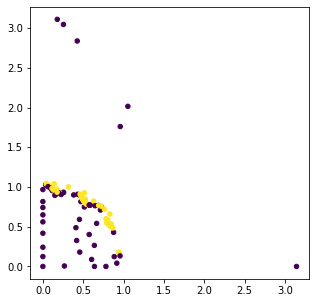

In [21]:
# plot objective results
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(5,5))

train_y = X.results['objectives'].numpy()

ax.scatter(*train_y.T, c = X.results['feasibility'], s=20)
